<a href="https://colab.research.google.com/github/VTNay/MEC557-Project/blob/Ma/MEC557_Weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MEC 557 - Apprentissage Automatique pour le climat et l"énérgie (2023-2024)
- **Vo Thoi Nay**, nay.vo-thoi@polytechnique.edu
- **Zhichuan Ma**, zhichuan.ma@polytechnique.edu

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2Fprojects.ipynb)

## **Introduction**

This project explores the application of machine learning in addressing practical challenges in meteorology, with a focus on a network of five weather stations located in Paris, Brest, London, Marseille, and Berlin. These stations monitor a variety of surface weather variables, including:

<center>

| Variable | Description                                      |
|----------|--------------------------------------------------|
| skt      | Skin Temperature                                 |
| u10      | 10-meter U Wind Component (wind speed east-west) |
| v10      | 10-meter V Wind Component (wind speed north-south)|
| t2m      | 2-meter Temperature                              |
| d2m      | 2-meter Dew Point Temperature                    |
| tcc      | Total Cloud Cover                                |
| sp       | Surface Pressure                                 |
| tp       | Total Precipitation                              |
| ssrd     | Surface Solar Radiation Downwards                |
| blh      | Boundary Layer Height                            |

</center>

The central challenge addressed in this project arises from a malfunction at the Paris weather station, leading to a gap in its data stream. The objective is to investigate the feasibility of using machine learning techniques to infer the weather conditions in Paris based on the data from the remaining stations in Brest, London, Marseille, and Berlin. This approach holds significant value, as it offers a potential solution for maintaining continuous weather monitoring in the event of individual station outages.

The project will likely involve analyzing correlations and patterns between the weather conditions reported by these stations and developing a predictive model to estimate the missing data for Paris. The key challenge is to accurately model the complex meteorological phenomena, providing reliable predictions in the absence of direct data from the Paris station.

### **Essential Preparation Guidelines (must read)**
Our project embraces collaboration through the use of Git and Google Colab, two powerful tools that enhance our team's efficiency and workflow. We have chosen to store our project data on Google Drive for easy access and sharing among team members.

To seamlessly integrate with our project setup, we recommend the following steps:

1.   **Download the Dataset**: First, obtain the dataset from our Moodle course page. This dataset forms the foundation of our analyses and experiments.
2.   **Create a Dedicated Project Folder**: In your Google Drive, establish a folder named **"PHY557_Project"**. This dedicated space will help you organize and manage project files effectively.
3.   **Upload the Dataset to the Folder**: Place the downloaded dataset into the "PHY557_Project" folder. This step ensures that all project-related data is centralized and accessible within your Google Drive.

Here is an example relevant path: "/content/drive/My Drive/PHY557_Project/weather/paris"








In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Weather Station**

<img alt="weather" src="https://github.com/VTNay/MEC557-Project/blob/main/images/map.png?raw=1" width=400>

- Suppose there are 5 weather stations that monitor the weather: Paris, Brest, London, Marseille and Berlin.
- The weather station in Paris breaks down
- Can we use the other stations to infer the weather in Paris

### **Glimpse on the dataset**

<img alt="weather" src="https://github.com/VTNay/MEC557-Project/blob/main/images/annual_temperature.png?raw=1" width=400>

- Surface variables: skt, u10, v10, t2m, d2m, tcc, sp, tp, ssrd, blh
- Temporal resolution: hourly
- Spatial resolution: N/A

## **Methodology**

<img alt="weather" src="https://github.com/VTNay/MEC557-Project/blob/main/images/methodology (2).png?raw=1" width=1000>

In our project, which involves a comprehensive dataset with 40 distinct features, our primary goal is to develop and refine models capable of predicting weather statistics for Paris. To achieve this, we have devised a structured approach for our data and model management:

1. **Dataset Division**: We start by splitting our dataset into two distinct parts. The first part is dedicated to model training, where we employ various strategies, including cross-validation, to identify the most effective model. Cross-validation helps in assessing the model's performance more reliably by using different subsets of the training data.

2. **Model Training and Selection**: During the training phase, several models are trained and evaluated. We utilize cross-validation to determine the best model based on its performance across different segments of our training data. This process ensures that the best hyperparameter is determined.

3. **Performance Testing**: The second part of the dataset is reserved for testing. This phase is crucial as it provides an unbiased evaluation of the model's performance. By applying the model to unseen data, we can gauge its effectiveness in real-world scenarios.

4. **Comparative Analysis**: Finally, we conduct a comprehensive comparison of the models' performances. This involves analyzing various metrics and aspects of each model to understand their strengths and weaknesses in predicting Paris weather statistics. The outcome of this comparison will guide us in selecting the most suitable model for our objective.

## **Data Processing and Cleaning**

This section focuses on the initial steps of handling our dataset: reading and storing the data followed by thorough cleaning. We place a special emphasis on identifying and addressing two primary issues - the presence of NaN (Not a Number) values and inconsistencies in dataset lengths across different cities. These steps are crucial to ensure the integrity and reliability of our analysis.

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
from functools import reduce
from matplotlib import pyplot as plt
from sklearn import preprocessing

# Define file paths for weather data of different cities
weather_paths = {
    'Paris': Path('/content/drive/My Drive/PHY557_Project/weather/paris'),
    'Brest': Path('/content/drive/My Drive/PHY557_Project/weather/brest'),
    'London': Path('/content/drive/My Drive/PHY557_Project/weather/london'),
    'Marseille': Path('/content/drive/My Drive/PHY557_Project/weather/marseille'),
    'Berlin': Path('/content/drive/My Drive/PHY557_Project/weather/berlin')
}

# Define the names of the files for each weather parameter
file_names = {
    't2m': 't2m.nc', 'blh': 'blh.nc', 'd2m': 'd2m.nc', 'skt': 'skt.nc',
    'sp': 'sp.nc', 'ssrd': 'ssrd.nc', 'tcc': 'tcc.nc', 'tp': 'tp.nc',
    'u10': 'u10.nc', 'v10': 'v10.nc'
}

# Initialize a dictionary to store weather data for each city
weather_data = {city: {} for city in weather_paths}

# Load and preprocess the data for each city
for city, path in weather_paths.items():
    for param, file_name in file_names.items():
        # Load the dataset
        dataset = xr.open_dataset(Path(path, file_name)).to_dataframe()
        # Drop unnecessary levels based on the parameter
        if param in ['d2m', 'blh']:
            dataset = dataset.droplevel([1, 2])
        else:
            dataset = dataset.droplevel([0, 1])
        # Store the processed data
        weather_data[city][param] = dataset
    # Merge data from different parameters into a single dataframe
    weather_data[city] = reduce(lambda left, right: pd.merge(
        left, right, left_index=True, right_index=True, how='outer'),
        weather_data[city].values())

# Function to rename columns with city prefix
def rename_columns(df, prefix):
    """Rename columns with a city prefix."""
    return df.rename(columns={col: f"{prefix}_{col}" for col in df.columns})

# Rename columns and concatenate data from all cities
combined_data = pd.concat([rename_columns(weather_data[city], city) for city in weather_data], axis=1)

# Data cleaning
# Drop rows with missing values
combined_data = combined_data.dropna()

# Split the combined data into features (X) and target (y)
X_raw = combined_data.iloc[:,10:]  # Features from all cities except Paris
y = combined_data['Paris_t2m']  # Target: temperature in Paris

# Assuming X_raw and y are your raw data arrays
X_normalized = (X_raw - X_raw.mean())/X_raw.std()
y_normalized = (y - y.mean())/y.std()


# Calculate the number of years in the dataset
n_years = y_normalized.index.year.max() - y_normalized.index.year.min() + 1

print(X_normalized.columns)
print(y)
print('Number of years: {}'.format(n_years))

Index(['Brest_t2m', 'Brest_blh', 'Brest_d2m', 'Brest_skt', 'Brest_sp',
       'Brest_ssrd', 'Brest_tcc', 'Brest_tp', 'Brest_u10', 'Brest_v10',
       'London_t2m', 'London_blh', 'London_d2m', 'London_skt', 'London_sp',
       'London_ssrd', 'London_tcc', 'London_tp', 'London_u10', 'London_v10',
       'Marseille_t2m', 'Marseille_blh', 'Marseille_d2m', 'Marseille_skt',
       'Marseille_sp', 'Marseille_ssrd', 'Marseille_tcc', 'Marseille_tp',
       'Marseille_u10', 'Marseille_v10', 'Berlin_t2m', 'Berlin_blh',
       'Berlin_d2m', 'Berlin_skt', 'Berlin_sp', 'Berlin_ssrd', 'Berlin_tcc',
       'Berlin_tp', 'Berlin_u10', 'Berlin_v10'],
      dtype='object')
time
1980-01-01 07:00:00    272.039154
1980-01-01 08:00:00    272.022308
1980-01-01 09:00:00    271.751892
1980-01-01 10:00:00    274.506470
1980-01-01 11:00:00    275.079346
                          ...    
2019-12-31 19:00:00    272.958130
2019-12-31 20:00:00    272.240845
2019-12-31 21:00:00    271.729919
2019-12-31 22:00:00    273.

## **Reducing the Dimension**
The necessity to reduce the dimensions of our feature set is primarily driven by constraints in available RAM. Given the extensive volume of our dataset, directly applying high-degree polynomial regression (such as degree = 3) is not viable due to the significant computational resources it requires.

To address this challenge, we have adopted two distinct methods: Principal Component Analysis (PCA) and Lasso Regression.

### **PCA**

PCA is a powerful technique for dimensionality reduction. It works by identifying the most significant features in terms of variance and transforming the original features into a new set of uncorrelated features (principal components). This process not only reduces the computational load but also retains the most crucial information contained in the data.

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd

def apply_pca(X, n_components=20):
    """
    Applies PCA to reduce the number of features.
    Args:
    X (DataFrame): The input features dataset.
    n_components (int): The number of principal components to keep.
    Returns:
    DataFrame: Transformed feature set with reduced dimensions.
    """
    # Initialize PCA
    pca = PCA(n_components=n_components)
    # Fit PCA on the dataset
    pca.fit(X)
    # Transform the dataset
    X_pca = pca.transform(X)
    # Convert to DataFrame for easier handling
    X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
    return X_pca_df

### **Lasso**
Lasso is a linear model that uses this cost function:

$$
\frac{1}{2N_{\text{training}}} \sum_{i=1}^{N_{\text{training}}} \left( y^{(i)}_{\text{real}} - y^{(i)}_{\text{pred}} \right)^2 + \alpha \sum_{j=1}^{n} |a_j|
$$

$a_j$ is the coefficient of the j-th feature. The final term is called $l_1$ penalty and $\alpha$ is a hyperparameter that tunes the intensity of this penalty term. The higher the coefficient of a feature, the higher the value of the cost function. So, the idea of Lasso regression is to optimize the cost function reducing the absolute values of the coefficients.


In [ ]:
from sklearn.linear_model import LassoCV
import pandas as pd

def apply_lasso(X, y, n_features_to_select):
    """
    Applies Lasso regression to select features.

    Args:
    X (DataFrame): The input features dataset.
    y (Series): The target dataset.
    n_features_to_select (int): The desired number of features to select.

    Returns:
    DataFrame: The reduced feature set.
    List of tuples: The list of features with their corresponding absolute coefficient values.
    """
    # Initialize LassoCV with cross-validation to find the optimal alpha
    lasso = LassoCV(cv=5)

    # Fit LassoCV on the dataset
    lasso.fit(X, y)

    # Get the coefficients
    coef = lasso.coef_

    # Combine features with their coefficients
    feature_coef = list(zip(X.columns, abs(coef)))

    # Sort features by the absolute value of their coefficient
    feature_coef = sorted(feature_coef, key=lambda x: x[1], reverse=True)

    # Select the top 'n_features_to_select'
    selected_features = [feature for feature, _ in feature_coef[:n_features_to_select]]

    return X[selected_features], feature_coef

## **Choose the number of features to reduce**

We developed the following code to strategically determine the number of features to reduce our dataset to.

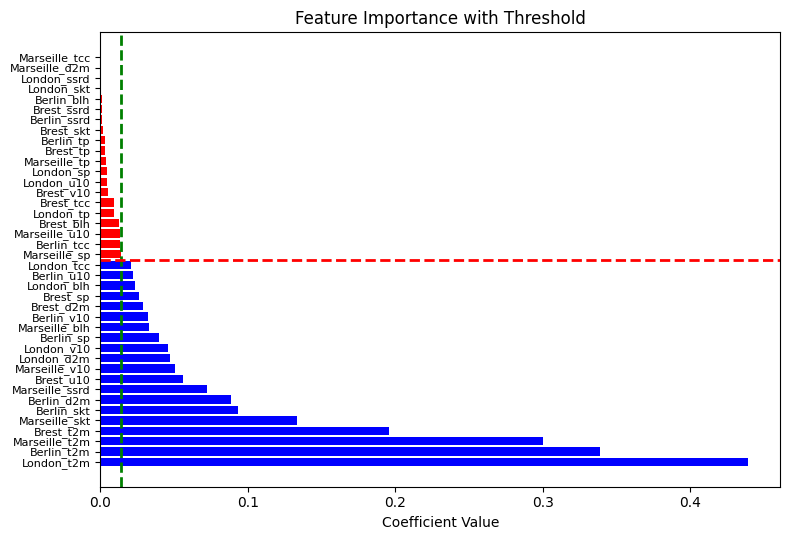

In [ ]:
X_lasso, feature_coef = apply_lasso(X_normalized, y_normalized, 20)
# Convert the list of tuples to a DataFrame for easier plotting
features, coefficients = zip(*feature_coef)
df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# Determine the threshold for the top 3 features
top_20_threshold = df['Coefficient'].nlargest(21).min()

# Create a color list, where features above the threshold are 'red' and others are 'blue'
colors = ['blue' if x > top_20_threshold else 'red' for x in df['Coefficient']]

# Plot the horizontal bar plot
plt.figure(figsize=(8, 5.5))
bars = plt.barh(df['Feature'], df['Coefficient'], color=colors)

# Add a vertical line for the threshold of the top 3 features
plt.axvline(x=top_20_threshold, color='green', linestyle='--', linewidth=2)

# Add a horizontal line at the position of the 3rd feature
top_20_feature_position = df[df['Coefficient'] > top_20_threshold].shape[0]
plt.axhline(y=top_20_feature_position-0.5, color='red', linestyle='--', linewidth=2)

plt.xlabel('Coefficient Value')
plt.yticks(fontsize = 8)
plt.title('Feature Importance with Threshold')
plt.tight_layout()

# Show the plot
plt.show()

## **Core Fucntion: poly_ridge**

Our project's central analytical component is encapsulated in the poly_ridge function. This function is meticulously designed to perform polynomial regression complemented by Ridge regularization, a method particularly suitable for handling multicollinearity and preventing overfitting in our model.

In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

def poly_ridge(degree, X, y, alpha_values, n_splits_cv, test_size):
    """
    Performs polynomial regression with Ridge regularization.

    Args:
    degree (int): The degree of the polynomial features.
    X (DataFrame): The features dataset.
    y (Series): The target dataset.
    alpha_values (array): Array of alpha values for regularization.
    n_splits_cv (int): Number of splits for cross-validation.
    test_size (float): The proportion of the dataset to include in the test split.

    Returns:
    dict: A dictionary containing model performance metrics and optimal parameters.
    """

    # Split the dataset into cross-validation and testing sets
    # Calculate the number of years to use for the test set
    n_test_years = int(n_years * test_size)
    # Define the cutoff year to separate the last 8 years
    cutoff_year = y.index.year.max() - (n_test_years - 1)
    # Create boolean masks for splitting the data
    cv_mask = y.index.year < cutoff_year
    test_mask = y.index.year >= cutoff_year

    # Split the data into cross-validation and test sets
    X_cv = X.loc[cv_mask]
    y_cv = y[cv_mask]
    X_test = X.loc[test_mask]
    y_test = y[test_mask]

    # Initialize arrays for storing scores and coefficients
    r2_validation = np.empty(len(alpha_values))
    # Set up the cross-validation configuration
    tscv = TimeSeriesSplit(n_splits=n_splits_cv)

    # Loop over different values of alpha (regularization strength)
    for i, alpha in enumerate(alpha_values):
        # Transform data to include polynomial features, include_bias=False because Ridge has the intercept by default
        polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
        # Create a pipeline with polynomial features and ridge regression
        model = make_pipeline(polynomial_features, Ridge(alpha=alpha))

        # Calculate the mean R^2 score from k-fold cross-validation
        r2_validation[i] = cross_val_score(model, X_cv, y_cv, cv=tscv).mean()

    # Find the index of the best alpha value
    i_best = np.argmax(r2_validation)
    alpha_best = alpha_values[i_best]

    # Train the model with the best alpha value on the full CV dataset
    best_model = make_pipeline(PolynomialFeatures(degree=degree, include_bias=False), Ridge(alpha=alpha_best))
    best_model.fit(X_cv, y_cv)

    # Calculate R^2 score on the test dataset
    r2_test = best_model.score(X_test, y_test)

    # Calculate MSE on the test dataset
    y_pred = best_model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred)

    # Return a dictionary containing the results
    return {
        'r2_validation': r2_validation,
        'i_best': i_best,
        'alpha_best': alpha_best,
        'r2_test': r2_test,
        'mse_test': mse_test
    }

## **Results**

### **40 features**

Due to memory constraints in handling a third-degree polynomial regression with 40 features, we have adjusted our approach to focus exclusively on Ridge regression for linear (first-degree) and second-degree polynomial models.

### **The determination of the range of alpha**
We tested several ranges of alpha_values and np.logspace(1, 3, 50) is the best choice where the best values of all models of 40 features and 20 features rely on this range

In [ ]:
alpha_values_40 =np.logspace(1, 3, 50)

In [ ]:
# Degree 1
results_40_linear = poly_ridge(degree=1, X=X_normalized, y=y_normalized, alpha_values=alpha_values_40, n_splits_cv=5, test_size=0.25)
print(results_40_linear)

{'r2_validation': array([0.91532801, 0.91532893, 0.91532991, 0.91533098, 0.91533217,
       0.9153334 , 0.91533475, 0.91533625, 0.91533783, 0.91533957,
       0.91534138, 0.91534336, 0.91534552, 0.9153477 , 0.91535014,
       0.91535265, 0.91535529, 0.9153581 , 0.915361  , 0.91536399,
       0.91536718, 0.9153703 , 0.91537347, 0.91537666, 0.91537974,
       0.91538272, 0.9153854 , 0.91538783, 0.91538979, 0.91539112,
       0.91539183, 0.91539151, 0.9153901 , 0.91538732, 0.91538287,
       0.91537649, 0.91536771, 0.91535629, 0.91534171, 0.91532345,
       0.91530121, 0.91527417, 0.91524196, 0.91520369, 0.91515898,
       0.91510694, 0.915047  , 0.91497835, 0.91490025, 0.91481209]), 'i_best': 30, 'alpha_best': 167.68329368110065, 'r2_test': 0.914225190841697, 'mse_test': 0.08770794}


In [ ]:
# Degree 2
results_40_second = poly_ridge(degree=2, X=X_normalized, y=y_normalized, alpha_values=alpha_values_40, n_splits_cv=5, test_size=0.25)

In [ ]:
print(results_40_second)

{'r2_validation': array([0.93219   , 0.93220364, 0.93221997, 0.93223462, 0.93225272,
       0.93226891, 0.9322869 , 0.93230479, 0.93232481, 0.93234438,
       0.93236596, 0.93238614, 0.93240771, 0.93243106, 0.93245441,
       0.93247677, 0.93250212, 0.93252525, 0.93255103, 0.93257522,
       0.93260055, 0.93262591, 0.93265039, 0.93267539, 0.93270011,
       0.93272331, 0.93274591, 0.93276743, 0.93278812, 0.93280699,
       0.9328241 , 0.93283899, 0.93285106, 0.93286134, 0.93286833,
       0.93287118, 0.93287069, 0.93286515, 0.93285571, 0.93284014,
       0.93281986, 0.9327934 , 0.93275991, 0.93271942, 0.93267162,
       0.93261601, 0.93255174, 0.93247867, 0.93239645, 0.9323047 ]), 'i_best': 35, 'alpha_best': 268.26957952797244, 'r2_test': 0.9356094532859576, 'mse_test': 0.06584173}


### **20 features**

In [ ]:
alpha_values_20 =np.logspace(2, 4, 100)

### **Getting the results for 20 features (PCA)**

In [ ]:
X_20_PCA = apply_pca(X_normalized, 20)
alpha_values_20_PCA =np.logspace(1, 4, 100)

In [ ]:
# Degree 1
results_20_linear_PCA = poly_ridge(degree=1, X=X_20_PCA, y=y_normalized, alpha_values=alpha_values_20_PCA, n_splits_cv=5, test_size=0.25)
print(results_20_linear_PCA)

{'r2_validation': array([0.89952015, 0.89952015, 0.89952016, 0.89952016, 0.89952015,
       0.89952015, 0.89952016, 0.89952015, 0.89952015, 0.89952016,
       0.89952016, 0.89952016, 0.89952016, 0.89952016, 0.89952016,
       0.89952016, 0.89952015, 0.89952016, 0.89952016, 0.89952016,
       0.89952016, 0.89952016, 0.89952016, 0.89952016, 0.89952015,
       0.89952015, 0.89952015, 0.89952015, 0.89952014, 0.89952013,
       0.89952014, 0.89952012, 0.89952012, 0.89952011, 0.8995201 ,
       0.89952008, 0.89952007, 0.89952006, 0.89952003, 0.89952   ,
       0.89951998, 0.89951995, 0.89951991, 0.89951986, 0.89951981,
       0.89951975, 0.89951968, 0.89951959, 0.89951949, 0.8995194 ,
       0.89951926, 0.89951911, 0.89951894, 0.89951875, 0.89951852,
       0.89951826, 0.89951796, 0.89951761, 0.89951722, 0.89951676,
       0.89951624, 0.89951563, 0.89951495, 0.89951416, 0.89951326,
       0.89951222, 0.89951104, 0.89950968, 0.89950813, 0.89950637,
       0.89950434, 0.89950205, 0.89949942, 0

In [ ]:
# Degree 2
results_20_second_PCA = poly_ridge(degree=2, X=X_20_PCA, y=y_normalized, alpha_values=alpha_values_20_PCA, n_splits_cv=5, test_size=0.25)
print(results_20_second_PCA)

{'r2_validation': array([0.91019335, 0.91019368, 0.9101941 , 0.91019451, 0.91019493,
       0.91019534, 0.91019584, 0.91019636, 0.91019692, 0.91019755,
       0.91019818, 0.91019885, 0.91019955, 0.91020039, 0.91020123,
       0.91020208, 0.91020307, 0.91020413, 0.91020522, 0.91020642,
       0.91020767, 0.91020899, 0.91021047, 0.91021201, 0.91021364,
       0.91021545, 0.91021734, 0.91021936, 0.91022154, 0.91022385,
       0.91022635, 0.91022896, 0.91023176, 0.91023478, 0.91023801,
       0.91024144, 0.91024509, 0.91024901, 0.91025313, 0.91025756,
       0.91026226, 0.91026727, 0.9102726 , 0.91027823, 0.91028426,
       0.91029066, 0.91029743, 0.91030461, 0.91031219, 0.91032027,
       0.91032873, 0.91033773, 0.91034723, 0.9103572 , 0.91036777,
       0.91037887, 0.91039049, 0.91040273, 0.91041556, 0.91042897,
       0.91044297, 0.91045755, 0.91047277, 0.91048857, 0.91050496,
       0.91052193, 0.91053943, 0.91055741, 0.9105759 , 0.91059482,
       0.91061409, 0.91063372, 0.91065353, 0

In [ ]:
# Degree 2 with alpha = 0
results_20_second_PCA_0 = poly_ridge(degree=2, X=X_20_PCA, y=y_normalized, alpha_values= np.zeros(1), n_splits_cv=5, test_size=0.25)
print(results_20_second_PCA_0)

{'r2_validation': array([0.91018864]), 'i_best': 0, 'alpha_best': 0.0, 'r2_test': 0.9089024369432085, 'mse_test': 0.09315065}


In [ ]:
# Degree 3
results_20_third_PCA = poly_ridge(degree=3, X=X_20_PCA, y=y_normalized, alpha_values=alpha_values_20_PCA, n_splits_cv=5, test_size=0.25)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.91319e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.94988e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.67352e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.26138e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarnin

In [ ]:
print(results_20_third_PCA)

{'r2_validation': array([0.90665082, 0.90665381, 0.9066601 , 0.90666726, 0.90667534,
       0.90668014, 0.90668682, 0.90669561, 0.90670173, 0.90670924,
       0.90671937, 0.90672874, 0.90674081, 0.90674851, 0.90676068,
       0.90677548, 0.90678579, 0.90679815, 0.90681364, 0.90682761,
       0.90684758, 0.9068628 , 0.90688217, 0.90689959, 0.9069215 ,
       0.90694606, 0.90696581, 0.90699171, 0.9070167 , 0.90704496,
       0.90707108, 0.90710186, 0.90712872, 0.90716556, 0.90720206,
       0.90723486, 0.90727483, 0.90731437, 0.9073556 , 0.90740108,
       0.90744727, 0.90749506, 0.9075443 , 0.90759735, 0.90765182,
       0.90770783, 0.90776774, 0.90782647, 0.90789131, 0.90795858,
       0.90802635, 0.90809546, 0.90816766, 0.90824142, 0.90831893,
       0.90839714, 0.90847842, 0.90855951, 0.90864414, 0.90872931,
       0.90881337, 0.90890357, 0.90899001, 0.90907796, 0.90916933,
       0.90925751, 0.90934815, 0.90943878, 0.90952799, 0.90961486,
       0.9097019 , 0.90978777, 0.90987028, 0

In [ ]:
# Degree 3 with alpha = 0
results_20_third_PCA_0 = poly_ridge(degree=3, X=X_20_PCA, y=y_normalized, alpha_values=np.zeros(1), n_splits_cv=5, test_size=0.25)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.20129e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.71989e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.54506e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.17182e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarnin

In [ ]:
print(results_20_third_PCA_0)

{'r2_validation': array([0.90657593]), 'i_best': 0, 'alpha_best': 0.0, 'r2_test': 0.9157424660460168, 'mse_test': 0.08615646}


### **Getting the results for 20 features (Lasso)**

In [ ]:
X_20_Lasso, feature_coef = apply_lasso(X_normalized, y_normalized, 20)
alpha_values_20_Lasso =np.logspace(1, 4, 100)

In [ ]:
# Degree 1
results_20_linear_Lasso = poly_ridge(degree=1, X=X_20_Lasso, y=y_normalized, alpha_values=alpha_values_20_PCA, n_splits_cv=5, test_size=0.25)
print(results_20_linear_Lasso)

{'r2_validation': array([0.9186028 , 0.91860318, 0.91860357, 0.91860399, 0.91860445,
       0.91860494, 0.91860545, 0.91860597, 0.91860656, 0.91860717,
       0.91860779, 0.91860846, 0.91860922, 0.91860997, 0.91861073,
       0.91861156, 0.91861241, 0.91861332, 0.91861425, 0.91861523,
       0.91861623, 0.91861726, 0.91861836, 0.91861943, 0.91862054,
       0.91862167, 0.9186228 , 0.91862394, 0.91862505, 0.91862611,
       0.91862716, 0.91862814, 0.91862903, 0.91862981, 0.91863045,
       0.91863094, 0.91863119, 0.91863123, 0.91863096, 0.91863034,
       0.9186293 , 0.91862777, 0.9186257 , 0.91862299, 0.91861955,
       0.91861527, 0.91861006, 0.91860378, 0.91859625, 0.9185874 ,
       0.91857703, 0.91856497, 0.91855103, 0.91853502, 0.91851668,
       0.91849583, 0.91847219, 0.91844553, 0.91841556, 0.91838195,
       0.91834442, 0.91830264, 0.91825628, 0.91820496, 0.91814833,
       0.91808599, 0.91801757, 0.91794263, 0.91786077, 0.91777155,
       0.91767455, 0.91756931, 0.91745539, 0

In [ ]:
# Degree 2
results_20_second_Lasso = poly_ridge(degree=2, X=X_20_Lasso, y=y_normalized, alpha_values=alpha_values_20_Lasso, n_splits_cv=5, test_size=0.25)
print(results_20_second_Lasso)

{'r2_validation': array([0.93223174, 0.93223793, 0.93224416, 0.93225073, 0.93225814,
       0.93226522, 0.93227268, 0.93228047, 0.93228837, 0.9322971 ,
       0.93230563, 0.93231439, 0.93232358, 0.93233335, 0.93234271,
       0.9323528 , 0.93236278, 0.93237375, 0.93238436, 0.93239534,
       0.93240707, 0.9324184 , 0.93243051, 0.93244252, 0.93245483,
       0.93246747, 0.93248025, 0.93249298, 0.93250635, 0.93251953,
       0.93253298, 0.93254633, 0.93255981, 0.93257325, 0.93258667,
       0.93259996, 0.93261326, 0.93262624, 0.93263876, 0.93265101,
       0.93266269, 0.93267399, 0.93268446, 0.93269422, 0.93270307,
       0.93271077, 0.93271721, 0.93272244, 0.93272605, 0.93272778,
       0.93272768, 0.93272543, 0.93272064, 0.9327133 , 0.93270293,
       0.93268943, 0.93267242, 0.93265165, 0.93262683, 0.93259755,
       0.93256337, 0.93252424, 0.93247954, 0.93242908, 0.93237235,
       0.93230901, 0.93223878, 0.93216116, 0.93207582, 0.93198241,
       0.93188057, 0.93176992, 0.93165011, 0

In [42]:
# Degree 3
results_20_third_Lasso = poly_ridge(degree=3, X=X_20_Lasso, y=y_normalized, alpha_values=alpha_values_20_Lasso, n_splits_cv=5, test_size=0.25)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.50975e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.05219e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.67865e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.05424e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarnin

In [43]:
print(results_20_third_Lasso)

{'r2_validation': array([0.92765831, 0.92774079, 0.92782298, 0.92787091, 0.92792729,
       0.92799976, 0.92810845, 0.92812239, 0.92820365, 0.92827478,
       0.92833334, 0.928458  , 0.92852936, 0.92860871, 0.92870577,
       0.92878762, 0.92890604, 0.92900536, 0.9291213 , 0.92919288,
       0.92932306, 0.92941771, 0.92953622, 0.92963917, 0.92976587,
       0.92988678, 0.93000714, 0.93012561, 0.93023442, 0.93037166,
       0.93048219, 0.9306227 , 0.93074578, 0.93088057, 0.93100028,
       0.93112519, 0.9312576 , 0.93138023, 0.93151136, 0.93163324,
       0.93176444, 0.9318915 , 0.93201602, 0.93214099, 0.93225882,
       0.93237846, 0.93249559, 0.93261053, 0.93272292, 0.93283361,
       0.93294097, 0.93304315, 0.93314384, 0.93324534, 0.93334183,
       0.93343321, 0.93352176, 0.93360529, 0.93368909, 0.93376735,
       0.93384093, 0.93391143, 0.93397851, 0.93403939, 0.93409805,
       0.93415116, 0.93420113, 0.93424415, 0.93428304, 0.93431699,
       0.93434595, 0.93436834, 0.93438492, 0

## **Figures Plotting**

### **Plot_2d function**

In [44]:
import matplotlib.pyplot as plt
import numpy as np

def plot_3d(models, alpha_values, r2_validation_arrays):
    """
    Plots a 3D of ridge curves of different models .

    Parameters:
    models (list): A list of models for the X-axis.
    alpha_values (array): An array of alpha values for the Y-axis.
    r2_validation_arrays (list of arrays): A list of r2_validation for the Z-axis, each corresponding to a model.
    """
    X, Y = np.meshgrid(range(1, len(models) + 1), alpha_values)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Set the positions for the labels to be closer
    label_positions = np.linspace(1, 1.2, len(labels))
    for i, (label, z) in enumerate(zip(models, r2_validation_arrays)):
        X = np.full_like(z, label_positions[i])  # Adjusting label positions
        Y = alpha_values
        ax.scatter(X, np.log10(Y), z, label=models)  # Apply log scale transformation

    ax.set_xlabel('Models')
    ax.set_ylabel('Alpha Values')
    ax.set_zlabel('R2 validation')
    ax.set_title('Ridge regression with several models')
    ax.set_xticks(label_positions)
    ax.set_xticklabels(models)
    # Set the y ticks to represent the log scale
    y_ticks = np.logspace(np.log10(alpha_values.min()), np.log10(alpha_values.max()), num=5)
    ax.set_yticks(np.log10(y_ticks))
    ax.set_yticklabels(y_ticks)
    plt.show()


In [45]:
import matplotlib.pyplot as plt
import numpy as np

def plot_2d(models, alpha_values, r2_validation_arrays):
    """
    Plots a 2D of ridge curves of different models .

    Parameters:
    models (list): A list of models for the X-axis.
    alpha_values (array): An array of alpha values for the Y-axis.
    r2_validation_arrays (list of arrays): A list of r2_validation for the Z-axis, each corresponding to a model.
    """
    # Set up the plot
    fig, ax = plt.subplots()

    # Plot each set of data
    for i,z in enumerate(r2_validation_arrays):
        ax.plot(alpha_values, z, label=f"{models[i]}")

    ax.set_xscale('log')
    ax.set_xlabel('Alpha values')
    ax.set_ylabel('R2 validation')
    ax.set_title('Ridge regression with several models')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, ncol=2)

    plt.show()

### **40 features figures**

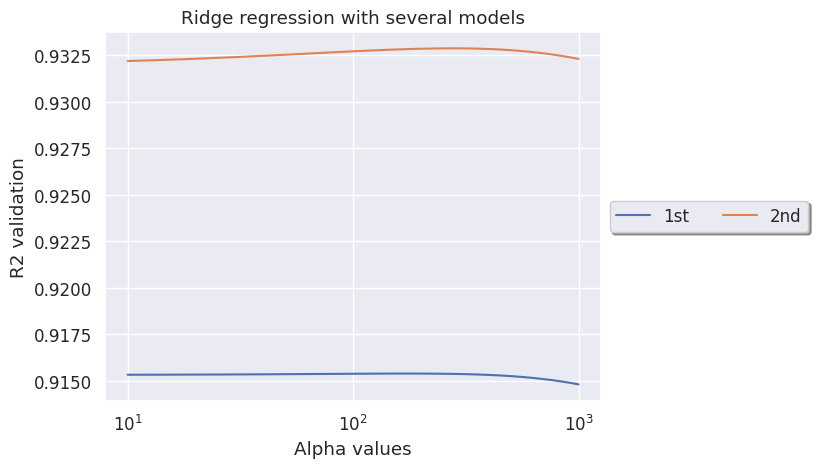

In [72]:
# 2D plot
models = ['1st', '2nd']
alpha_values = alpha_values_40
z_1st = results_40_linear['r2_validation']
z_2nd = results_40_second['r2_validation']
plot_2d(models, alpha_values, [z_1st, z_2nd])

### **20 features figures**: Dimensionality Reduction Impact (PCA and Lasso)

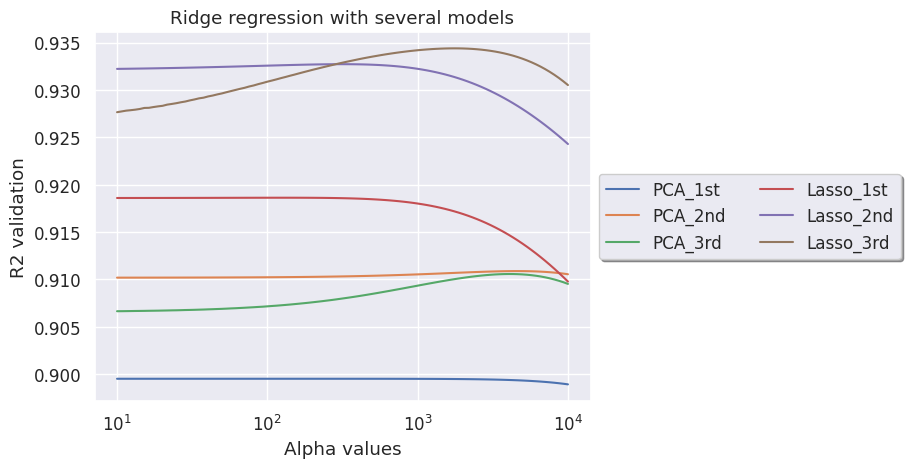

In [73]:
# 2D plot for 20 features using PCA
models = ['PCA_1st', 'PCA_2nd','PCA_3rd', 'Lasso_1st', 'Lasso_2nd','Lasso_3rd']
alpha_values = alpha_values_20_PCA
z_1st_PCA = results_20_linear_PCA['r2_validation']
z_2nd_PCA = results_20_second_PCA['r2_validation']
z_3rd_PCA = results_20_third_PCA['r2_validation']
z_1st_Lasso = results_20_linear_Lasso['r2_validation']
z_2nd_Lasso = results_20_second_Lasso['r2_validation']
z_3rd_Lasso = results_20_third_Lasso['r2_validation']
plot_2d(models, alpha_values, [z_1st_PCA, z_2nd_PCA, z_3rd_PCA, z_1st_Lasso, z_2nd_Lasso, z_3rd_Lasso])

## **Neural Network Prediction**
Besides the polynomial regression prediction, we also tried to use neural network to do the prediction.

Here, we do 3 kinds of predictions: 40 features, 20 features after PCA, 20 features after Lasso.

The epochs are set to 100.

The structure of the neural network is a feedforward network consisting of three layers:

1. Input Layer: Composed of 64 neurons, receiving input features.
2. Hidden Layer: A single hidden layer with 32 neurons.
3. Output Layer: A single neuron producing a continuous output value, suitable for regression tasks.

The network uses ReLU activation functions in the input and hidden layers to introduce non-linearity.

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

def neural_network_regression(X, y, epochs=100, batch_size=32, test_size=0.25):
    """
    Trains a neural network for regression.

    Args:
    X (DataFrame): The features dataset.
    y (Series): The target dataset.
    epochs (int): Number of epochs for training.
    batch_size (int): Batch size for training.
    test_size (float): Proportion of the dataset to include in the test split.

    Returns:
    model: Trained neural network model.
    history: Training history object.
    """

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the neural network architecture
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)  # Single output node for regression
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    # Evaluate the model on the test set
    test_loss = model.evaluate(X_test, y_test)
    print(f'Test MSE: {test_loss}')

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f'R² Score: {r2}')

    return model, history, r2, test_loss

### **Direct neural network prediction for 40 features**

In [50]:
results_40_neural_network = neural_network_regression(X=X_normalized, y=y_normalized)

Epoch 1/100
6575/6575 [==============================] - 16s 2ms/step - loss: 0.0709 - val_loss: 0.0581
Epoch 2/100
6575/6575 [==============================] - 17s 3ms/step - loss: 0.0574 - val_loss: 0.0576
Epoch 3/100
6575/6575 [==============================] - 15s 2ms/step - loss: 0.0544 - val_loss: 0.0520
Epoch 4/100
6575/6575 [==============================] - 15s 2ms/step - loss: 0.0526 - val_loss: 0.0520
Epoch 5/100
6575/6575 [==============================] - 15s 2ms/step - loss: 0.0513 - val_loss: 0.0528
Epoch 6/100
6575/6575 [==============================] - 18s 3ms/step - loss: 0.0505 - val_loss: 0.0507
Epoch 7/100
6575/6575 [==============================] - 19s 3ms/step - loss: 0.0499 - val_loss: 0.0520
Epoch 8/100
6575/6575 [==============================] - 15s 2ms/step - loss: 0.0492 - val_loss: 0.0495
Epoch 9/100
6575/6575 [==============================] - 18s 3ms/step - loss: 0.0489 - val_loss: 0.0510
Epoch 10/100
6575/6575 [==============================] - 16s 2m

### **Neural network prediction for 20 features (after PCA)**

In [51]:
results_20_PCA_neural_network = neural_network_regression(X=X_20_PCA, y=y_normalized)

Epoch 1/100
6575/6575 [==============================] - 16s 2ms/step - loss: 0.0924 - val_loss: 0.0812
Epoch 2/100
6575/6575 [==============================] - 15s 2ms/step - loss: 0.0790 - val_loss: 0.0779
Epoch 3/100
6575/6575 [==============================] - 15s 2ms/step - loss: 0.0760 - val_loss: 0.0753
Epoch 4/100
6575/6575 [==============================] - 16s 2ms/step - loss: 0.0742 - val_loss: 0.0748
Epoch 5/100
6575/6575 [==============================] - 16s 2ms/step - loss: 0.0730 - val_loss: 0.0738
Epoch 6/100
6575/6575 [==============================] - 16s 2ms/step - loss: 0.0720 - val_loss: 0.0723
Epoch 7/100
6575/6575 [==============================] - 16s 2ms/step - loss: 0.0711 - val_loss: 0.0732
Epoch 8/100
6575/6575 [==============================] - 16s 2ms/step - loss: 0.0705 - val_loss: 0.0724
Epoch 9/100
6575/6575 [==============================] - 15s 2ms/step - loss: 0.0700 - val_loss: 0.0722
Epoch 10/100
6575/6575 [==============================] - 15s 2m

### **Neural network prediction for 20 features (after Lasso)**

In [52]:
results_20_Lasso_neural_network = neural_network_regression(X=X_20_Lasso, y=y_normalized)

Epoch 1/100
6575/6575 [==============================] - 19s 3ms/step - loss: 0.0702 - val_loss: 0.0629
Epoch 2/100
6575/6575 [==============================] - 16s 2ms/step - loss: 0.0609 - val_loss: 0.0594
Epoch 3/100
6575/6575 [==============================] - 16s 2ms/step - loss: 0.0589 - val_loss: 0.0578
Epoch 4/100
6575/6575 [==============================] - 16s 2ms/step - loss: 0.0578 - val_loss: 0.0567
Epoch 5/100
6575/6575 [==============================] - 15s 2ms/step - loss: 0.0569 - val_loss: 0.0567
Epoch 6/100
6575/6575 [==============================] - 15s 2ms/step - loss: 0.0563 - val_loss: 0.0563
Epoch 7/100
6575/6575 [==============================] - 17s 3ms/step - loss: 0.0557 - val_loss: 0.0557
Epoch 8/100
6575/6575 [==============================] - 16s 2ms/step - loss: 0.0553 - val_loss: 0.0577
Epoch 9/100
6575/6575 [==============================] - 15s 2ms/step - loss: 0.0550 - val_loss: 0.0562
Epoch 10/100
6575/6575 [==============================] - 15s 2m

### **Learning Curve Plotting**

In [78]:
def plot_learning_curves(history):
    """
    Plots the learning curves for training and validation loss.

    Args:
    history: Training history object returned by the fit method of a keras model.
    """
    # Extract loss and validation loss from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create a range for the number of epochs
    epochs = range(1, len(loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()

    plt.show()



#### **Learning Curve for direct neural network prediction for 40 features**

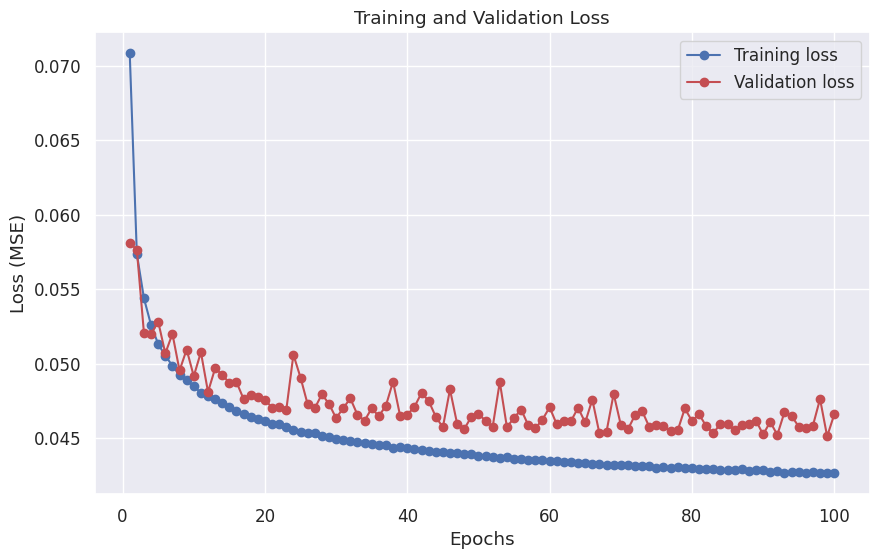

In [77]:
plot_learning_curves(results_40_neural_network[1])

#### **Learning Curve for neural network prediction for 20 features (after PCA)**

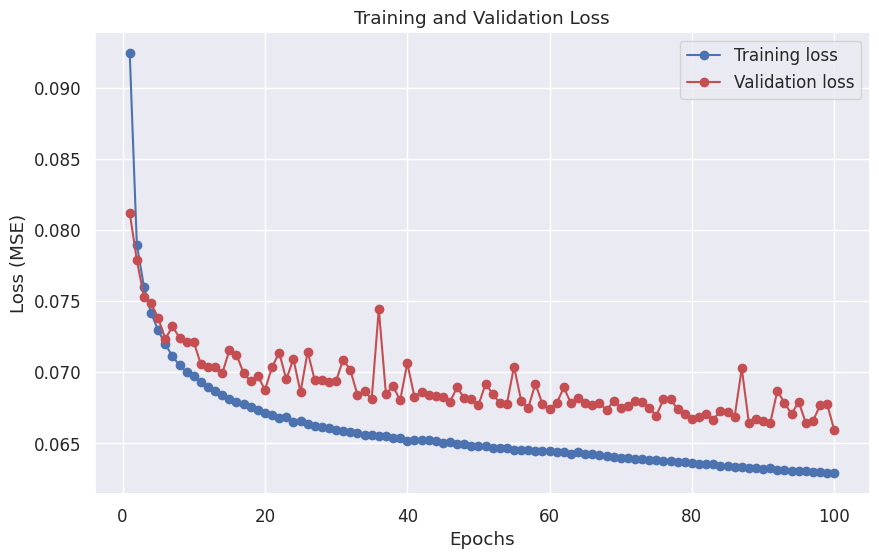

In [75]:
plot_learning_curves(results_20_PCA_neural_network[1])

#### **Learning Curve for neural network prediction for 20 features (after Lasso)**

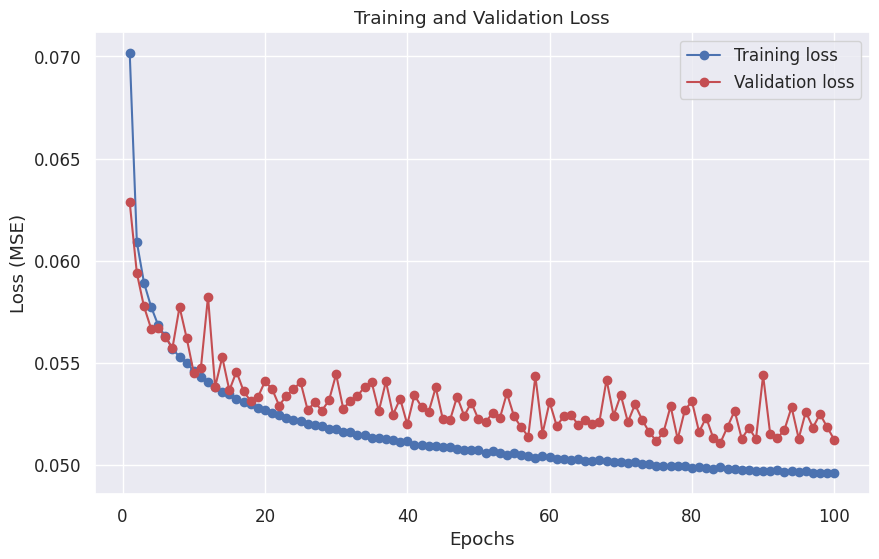

In [74]:
plot_learning_curves(results_20_Lasso_neural_network[1])

## **Plot R2 test and MSE of all the models**

Text(0.5, 1.0, 'R2 test score for different models')

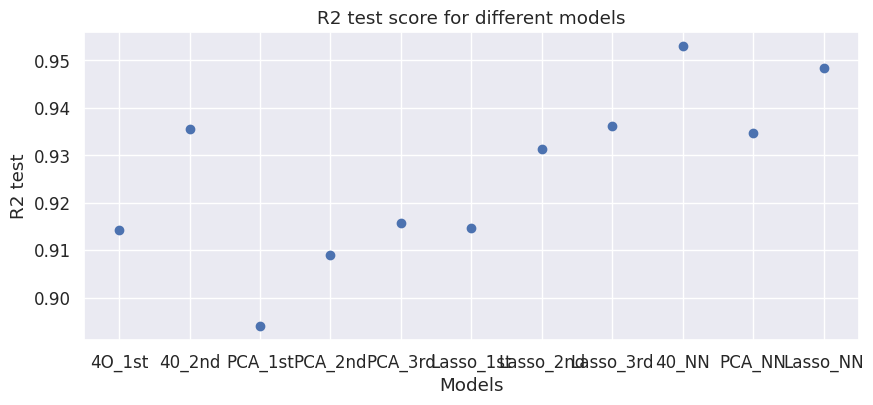

In [71]:
# Set up the plot
models = ['4O_1st', '40_2nd', 'PCA_1st', 'PCA_2nd','PCA_3rd', 'Lasso_1st', 'Lasso_2nd','Lasso_3rd','40_NN', 'PCA_NN', 'Lasso_NN']
r2_tests = [
    results_40_linear['r2_test'], results_40_second['r2_test'],
    results_20_linear_PCA['r2_test'], results_20_second_PCA['r2_test'],
    results_20_third_PCA['r2_test'], results_20_linear_Lasso['r2_test'],
    results_20_second_Lasso['r2_test'], results_20_third_Lasso['r2_test'],
    results_40_neural_network[2], results_20_PCA_neural_network[2], results_20_Lasso_neural_network[2]
]
fig, ax = plt.subplots(figsize = (10,4))
ax.scatter(models, r2_tests)
ax.set_xlabel('Models')
ax.set_ylabel('R2 test')
ax.set_title('R2 test score for different models')

Text(0.5, 1.0, 'MSE for different models')

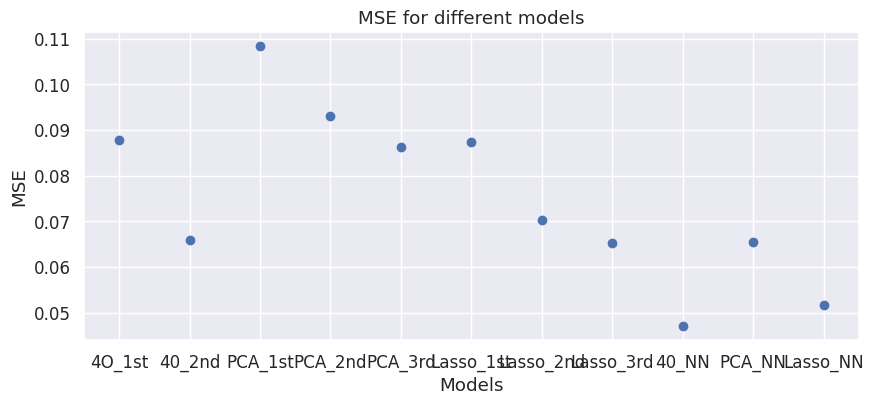

In [70]:
# Set up the plot
models = ['4O_1st', '40_2nd', 'PCA_1st', 'PCA_2nd','PCA_3rd', 'Lasso_1st', 'Lasso_2nd','Lasso_3rd','40_NN', 'PCA_NN', 'Lasso_NN']
mse = [
    results_40_linear['mse_test'], results_40_second['mse_test'], results_20_linear_PCA['mse_test'], results_20_second_PCA['mse_test'], results_20_third_PCA['mse_test'],
    results_20_linear_Lasso['mse_test'], results_20_second_Lasso['mse_test'], results_20_third_Lasso['mse_test'], results_40_neural_network[3], results_20_PCA_neural_network[3], results_20_Lasso_neural_network[3]
]
fig, ax = plt.subplots(figsize = (10,4))
ax.scatter(models, mse)
ax.set_xlabel('Models')
ax.set_ylabel('MSE')
ax.set_title('MSE for different models')

### **Heat Map of the Performance Matrix**


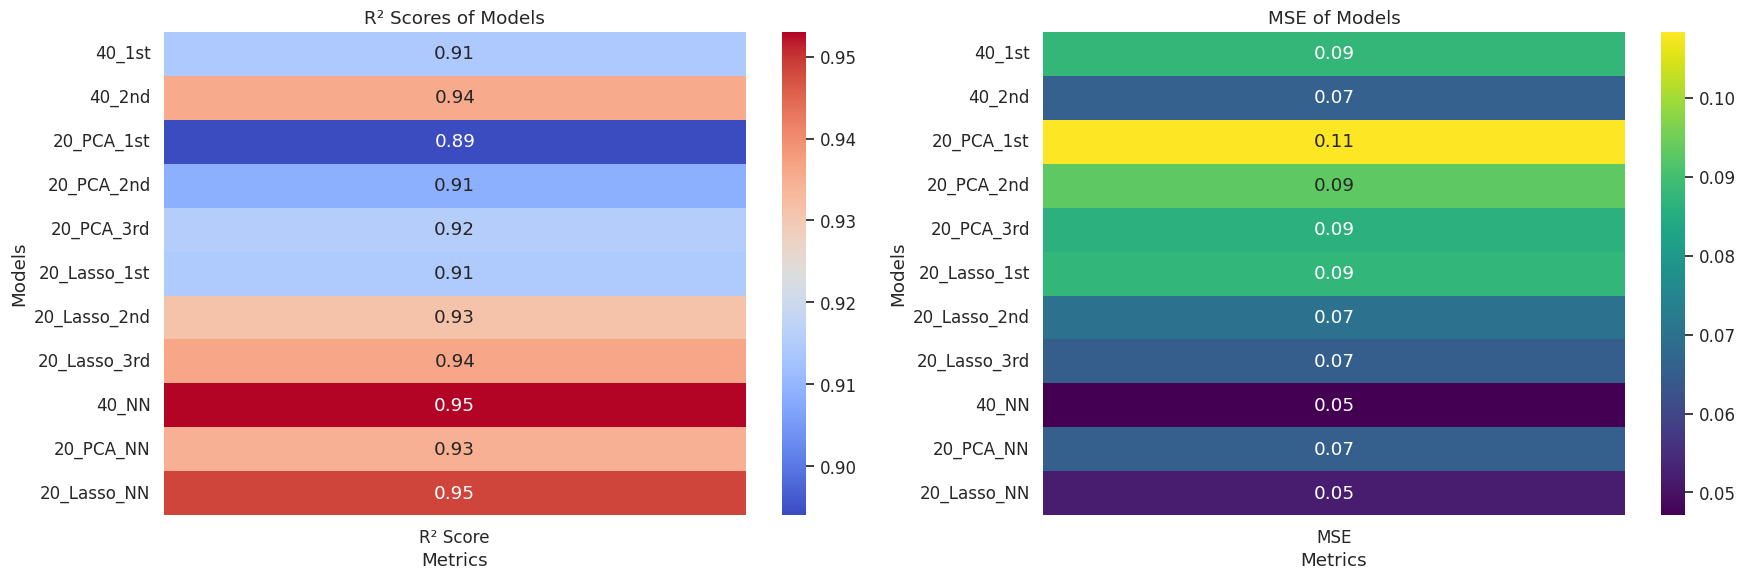

In [69]:
import seaborn as sns
# Models with various configurations and two metrics (R² score and MSE)
models = ['40_1st', '40_2nd', '20_PCA_1st', '20_PCA_2nd', '20_PCA_3rd', '20_Lasso_1st', '20_Lasso_2nd', '20_Lasso_3rd', '40_NN', '20_PCA_NN', '20_Lasso_NN']
metrics = ['R² Score', 'MSE']

r2_scores = [results_40_linear['r2_test'], results_40_second['r2_test'],
             results_20_linear_PCA['r2_test'], results_20_second_PCA['r2_test'],
             results_20_third_PCA['r2_test'], results_20_linear_Lasso['r2_test'],
             results_20_second_Lasso['r2_test'], results_20_third_Lasso['r2_test'],
             results_40_neural_network[2], results_20_PCA_neural_network[2],
             results_20_Lasso_neural_network[2]]
mse_values = [results_40_linear['mse_test'], results_40_second['mse_test'], results_20_linear_PCA['mse_test'], results_20_second_PCA['mse_test'], results_20_third_PCA['mse_test'],
    results_20_linear_Lasso['mse_test'], results_20_second_Lasso['mse_test'], results_20_third_Lasso['mse_test'], results_40_neural_network[3], results_20_PCA_neural_network[3], results_20_Lasso_neural_network[3]]  # Replace with actual MSE values

# Creating DataFrames for each metric
df_r2 = pd.DataFrame({'R² Score': r2_scores}, index=models)
df_mse = pd.DataFrame({'MSE': mse_values}, index=models)

# Setting up the matplotlib figure
fig, axs = plt.subplots(ncols=2, figsize=(18, 6))

# Creating two heatmaps side by side
sns.heatmap(df_r2, annot=True, cmap='coolwarm', fmt=".2f", ax=axs[0])
sns.heatmap(df_mse, annot=True, cmap='viridis', fmt=".2f", ax=axs[1])

axs[0].set_title('R² Scores of Models')
axs[0].set_xlabel('Metrics')
axs[0].set_ylabel('Models')

axs[1].set_title('MSE of Models')
axs[1].set_xlabel('Metrics')
axs[1].set_ylabel('Models')

plt.tight_layout()
plt.show()

## **Discussion and Conclusion**

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_lmd.jpg?raw=1" style="display: inline-block"/>

<img alt="Logo IPSL" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_ipsl.png?raw=1" style="display: inline-block"/>

<img alt="Logo E4C" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_e4c_final.png?raw=1" style="display: inline-block"/>

<img alt="Logo EP" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_ep.png?raw=1" style="display: inline-block"/>

<img alt="Logo SU" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_su.png?raw=1" style="display: inline-block"/>

<img alt="Logo ENS" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_ens.jpg?raw=1" style="display: inline-block"/>

<img alt="Logo CNRS" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_cnrs.png?raw=1" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>